# GAN Architectures

## Import Statements

In [1]:
# python level imports
import chess

import chess.svg
import cv2

from IPython.display import display, SVG

import numpy as np
import random
from tqdm import tqdm
from importlib import reload
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import utils
reload(utils)
import utils

import matplotlib.pyplot as plt

C:\Users\osama\anaconda3\lib\site-packages\torch\__init__.py:690: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [2]:
if torch.cuda.is_available():
    # Set default tensor type to CUDA tensors
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    
else:
    
    torch.set_default_tensor_type(torch.FloatTensor)
 
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

made_loader = False

True


In [ ]:
# run this cell to empty cuda cache to avoid cuda memory issues
torch.cuda.empty_cache()
gc.collect()

0

In [3]:
# function to clear cuda from any point in code
def clear_cuda():

    torch.cuda.empty_cache()
    gc.collect()
    

In [4]:
# import utils files
from utils.Datasets import *

import utils.Dataloading
reload(utils.Dataloading)
from utils.Dataloading import *
from utils.Game_playing import *

import utils.Playing_agents
reload(utils.Playing_agents)
from utils.Playing_agents import *

from utils.CSV_data import *
from utils.Puzzles import *

## Behavioral Cloning Model and Data Import

In [5]:
# model architecture taken from behavioral_cloning.ipynb
class MLPv2_1(nn.Module):

    def __init__(self):

        super().__init__()
        self.conv1 = nn.Conv2d(14, 64, 3, 1, padding=1, padding_mode = 'zeros')

        self.layers = nn.ModuleList()

        self.depth = 6

        for _ in range(self.depth):
            self.layers.append(nn.Conv2d(64,64, 3, 1, padding=1, padding_mode = 'zeros'))
            self.layers.append(nn.BatchNorm2d(64))
            self.layers.append(nn.Conv2d(64,64, 3, 1, padding=1, padding_mode = 'zeros'))
            self.layers.append(nn.BatchNorm2d(64))

        self.linear = nn.Linear(4096, 128)

    def forward(self, x):

        x = self.conv1(x)

        for i in range(self.depth):
            j = i*4
            ph = x.clone()
            ph = self.layers[j](ph)
            ph = self.layers[j+1](ph)
            ph = F.relu(ph)
            ph = self.layers[j+2](ph)
            ph = self.layers[j+3](ph)

            x = x + ph
            x = F.relu(x)


        x = torch.flatten(x, start_dim=1)

        x = self.linear(x)

        minn, ila = x[:,:64], x[:,64:]

        return minn, ila

In [6]:
#import the behavioral cloning model from saved models
RDv2 = torch.load("Models/RDv2.3 CB.pt", map_location= device)
RDv2_player = lambda board: network_agent_prob_conv(board, RDv2)

In [7]:
def load_stockfish_data(N=2_000_000):

    """returns the boards, metadata, human moves and stockfish moves for N games"""
    
    file_path = "Data/StockData.csv"
    new_data = True
    epsilon = 1e-5
    
    df = pd.read_csv(file_path, nrows=N)
    ind_map = index_map.cpu().numpy()
    
    
    df.dropna(axis=0, inplace=True)
    df.reset_index(inplace=True)

    
    fens = np.array(df['FENs'])
    moves = np.zeros((len(fens), 128))
    h_moves = np.zeros((len(fens), 128))

    bitboards, meta = zip(*[fen_to_board(x) for x in tqdm(fens, total=len(fens))])
    
    bitboards = np.asarray(bitboards)

    meta = np.asarray(meta)
    
    if new_data:

        moves[df.index,df['stock_moves'].apply(lambda x: chess.Move.from_uci(x).from_square)] = 1
        moves[df.index, 64 + df['stock_moves'].apply(lambda x: chess.Move.from_uci(x).to_square)] = 1
        
    else:
        
        for i in tqdm(range(4)):
            
            moves[df.index,df[f'move{i}'].apply(lambda x: chess.Move.from_uci(x).from_square)] += df[f'eval{i}'] + epsilon
            moves[df.index, 64 + df[f'move{i}'].apply(lambda x: chess.Move.from_uci(x).to_square)] += df[f'eval{i}'] + epsilon
        
    
    h_moves[df.index, df["hmoves"].apply(lambda x: chess.Move.from_uci(x).from_square)] = 1
    h_moves[df.index, 64 + df["hmoves"].apply(lambda x: chess.Move.from_uci(x).to_square)] = 1
    
    flipped_moves = np.zeros_like(moves)    
    flipped_moves[:,:64] = moves[:,ind_map]
    flipped_moves[:,64:] = moves[:,64+ind_map]
    #v_fens = np.vectorize(fen_to_board)
    moves = np.where(np.expand_dims(meta, 1), moves, flipped_moves)

    flipped_moves = np.zeros_like(h_moves)
    flipped_moves[:,:64] = h_moves[:,ind_map]
    flipped_moves[:,64:] = h_moves[:,64+ind_map]
    #v_fens = np.vectorize(fen_to_board)
    h_moves = np.where(np.expand_dims(meta, 1), h_moves, flipped_moves)
    
    #bitboards = np.array(list(map(fen_to_board, fens)))
    
    del df
    
    
    return bitboards, meta, h_moves, moves

In [ ]:
# download N boards of data
boards, meta, human_moves, stock_moves = load_stockfish_data(N = 500_000)

## BasicGAN

In [8]:
# Here, we define the generator architecture for the GAN
# Uncomment commented lines to run with BatchNorm
class generator_1(nn.Module):

    def __init__(self, conv_depth):

        """
        Defines the generator architecture

        :param conv_depth: int
        """

        super().__init__()
        self.conv1 = nn.Conv2d(14, 64, 3, 1, padding=1, padding_mode = 'zeros')
        
        self.conv_layers = nn.ModuleList()
        self.conv_depth = conv_depth
        
        for i in range(self.conv_depth):
            self.conv_layers.append(nn.Conv2d(64,64, 3, 1, padding=1, padding_mode = 'zeros'))
            #self.conv_layers.append(nn.BatchNorm2d(64))
            self.conv_layers.append(nn.Conv2d(64,64, 3, 1, padding=1, padding_mode = 'zeros'))
            #if i < self.conv_depth - 1:
                #self.conv_layers.append(nn.BatchNorm2d(64))

        self.linear = nn.Linear(4096, 128)

    def forward(self, x):
        """
        Takes in a board and outputs the move probabilities

        :param x: 14x8x8 chess bitboard
        :return: 128x1 move vector
        """


        x = self.conv1(x)
        
        for i in range(self.conv_depth):
            j = i*2
            ph = x.clone()
            ph = self.conv_layers[j](ph)
            #ph = self.conv_layers[j+1](ph)
            ph = F.relu(ph)
            ph = self.conv_layers[j+1](ph)
            #if i < self.conv_depth - 1:
                #ph = self.conv_layers[j+3](ph)
            
            x = x + ph
            x = F.relu(x)   
        
        x = torch.flatten(x, start_dim=1)

        x = self.linear(x)
        minn, ila = x[:,:64], x[:,64:]

        minn = F.softmax(minn, dim=1)
        ila = F.softmax(ila, dim=1)

        return torch.cat([minn, ila], dim=1).view(-1, 2, 8, 8)

In [9]:
# Here we define the architecture of the discriminator in the GAN architecture
class discriminator_1(nn.Module):

    def __init__(self, conv_depth):

        """
        Defines the discriminator architecture

        :param conv_depth: int
        """

        super().__init__()
        self.conv1 = nn.Conv2d(16, 64, 3, 1, padding=1, padding_mode = 'zeros')

        self.conv_layers = nn.ModuleList()
        self.conv_depth = conv_depth

        for _ in range(self.conv_depth):
            self.conv_layers.append(nn.Conv2d(64,64, 3, 1, padding=1, padding_mode = 'zeros'))
            self.conv_layers.append(nn.LayerNorm([64,8,8]))
            self.conv_layers.append(nn.Conv2d(64,64, 3, 1, padding=1, padding_mode = 'zeros'))
            self.conv_layers.append(nn.LayerNorm([64,8,8]))
            
        self.linear = nn.Linear(4096, 1)
    

    def forward(self, board, move):
        """
        Takes in a board and outputs the move probabilities

        :param board: 14x8x8 chess bitboard
        :param move: 128x1 move vector
        :return: probability of move being played by human
        """
        
        x = torch.cat((board, move), dim = 1)

        x = self.conv1(x)
        
        for i in range(self.conv_depth):
            j = i*2
            ph = x.clone()
            ph = self.conv_layers[j](ph)
            ph = self.conv_layers[j+1](ph)
            ph = F.leaky_relu(ph)
            ph = self.conv_layers[j+2](ph)
            ph = self.conv_layers[j+3](ph)
            
            x = x + ph
            x = F.leaky_relu(x)
                  
                  
        x = torch.flatten(x, start_dim=1)
        
        x = self.linear(x)
        x = F.sigmoid(x)
        
        return x

In [10]:
# We defind the final BasicGAN architecture
class GAN_1(nn.Module):
    #AI: 0, Human: 1
    def __init__(self, g_conv_depth, d_conv_depth, lr, pre_trained_g = None):

        """
        Defines the BasicGAN architecture

        :param g_conv_depth: int 
        :param d_conv_depth: int
        :param lr: float
        :param pre_trained_g: a previous network on which to train 
        """
        
        super().__init__()
                
        self.save_every = 2 # defines how often to save the GAN models

        self.alpha = 0.2
        
        # if we have a pre-trained model then make it the generator
        if pre_trained_g is not None:
            
            self.generator = pre_trained_g
            self.pre_trained = True
        
        else:
            
            self.generator = generator_1(g_conv_depth)
            self.pre_trained = False


        # define the current discriminator as specified above
        self.discriminator = discriminator_1(d_conv_depth)
        
        # dict to store important model statistics such as validation accuracy and loss
        self.logs = {"g_acc": [0], "d_acc_r": [0], "d_acc_f": [0], 
                     "g_loss": [0], "d_loss": [0],"d_dist_f": [0], "d_dist_r": [0], 
                     "cur_g_loss": 0, "cur_d_loss": 0}
        
        # this is to ensure a dataloader is in place
        self.made_loader = False
        
        # set up the optimizers and appropriate loss functions
        self.configure_optimizers(lr)
        self.categorical_loss_1 = torch.nn.CrossEntropyLoss()
        self.categorical_loss_2 = torch.nn.CrossEntropyLoss()
        
        
    # running the GAN is the same as running the generator
    def forward(self, x):
        return self.generator(x)
    
    # function that defines chosen loss function for the discriminator
    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)
    
    
    # this function is not used in BasicGAN. Only in StockGAN
    # this function trains the generator on the optimal stockfish moves
    def stockfish_train(self, train_boards, moves):

        
        self.generator.train()
        
        self.discriminator.eval()
        
        self.opt_g.zero_grad()

        fake_moves = self(train_boards)

        moves = moves.view(-1, 128)

        if self.pre_trained:

            fake_moves = F.softmax(fake_moves[0], dim=1), F.softmax(fake_moves[1], dim=1)
            g_loss = self.categorical_loss_1(fake_moves[0], moves[:,:64]) + self.categorical_loss_2(fake_moves[1], moves[:,64:])
            
        else:
            
            fake_moves = fake_moves.view(-1, 128)

            g_loss = self.categorical_loss_1(fake_moves[:,:64], moves[:,:64]) + self.categorical_loss_2(fake_moves[:,64:], moves[:,64:])
            
        #g_loss = torch.sum(torch.log((y - y_hat) + epsilon), dim=0)
        
        g_loss *= self.alpha

        self.logs["cur_g_loss"] += g_loss.item()

        g_loss.backward()

        self.opt_g.step()
    
    # this function trains the generator based on discriminator if train_generator is True
    # If train_generator is False, then the discriminaotr is trained
    def train_step(self, train_boards, real_moves, train_generator, prev_generator=None):

        self.discriminator.train()

        self.generator.train()

        epsilon = 1e-8
        
        #train generator
        if train_generator:
            
            self.discriminator.eval()

            self.opt_g.zero_grad()
            
            fake_moves = self(train_boards)
            
            if self.pre_trained:
                
                fake_moves = F.softmax(fake_moves[0], dim=1), F.softmax(fake_moves[1], dim=1)
                fake_moves = self.diffable_argmax_moves(torch.cat(fake_moves,dim=1)).view(-1,2,8,8)
                
            else:
                
                fake_moves = self.diffable_argmax_moves(fake_moves).view(-1,2,8,8)
            
            y_hat = self.discriminator(train_boards, fake_moves)
            
            y = torch.zeros(real_moves.size(0), 1).to(device)
            
            g_loss = -1 * self.adversarial_loss(y_hat, y)
                        
            self.logs["cur_g_loss"] += g_loss.item()
            
            g_loss.backward()

            self.opt_g.step()
              
        #discriminator training 
        else:

            self.generator.eval()

            self.opt_d.zero_grad()
            
            y_hat_real = self.discriminator(train_boards, real_moves)
            y_real = torch.ones(real_moves.size(0), 1).to(device)
            
            d_real_loss = self.adversarial_loss(y_hat_real, y_real)
            
            if prev_generator is not None:
                
                prev_fake_moves = prev_generator(train_boards[:len(train_boards)//8])
                fake_moves = self(train_boards[len(train_boards)//8:])

                if self.pre_trained:

                    fake_moves = F.softmax(fake_moves[0], dim=1), F.softmax(fake_moves[1], dim=1)
                    fake_moves = self.diffable_argmax_moves(torch.cat(fake_moves,dim=1)).view(-1,2,8,8).detach()
                    prev_fake_moves = F.softmax(prev_fake_moves[0], dim=1), F.softmax(prev_fake_moves[1], dim=1)
                    prev_fake_moves = self.diffable_argmax_moves((torch.cat(prev_fake_moves,dim=1))).view(-1,2,8,8).detach()

                else:

                    fake_moves = self.diffable_argmax_moves(fake_moves).view(-1,2,8,8).detach()
                    prev_fake_moves = self.diffable_argmax_moves(prev_fake_moves).view(-1,2,8,8).detach()
                
                fake_moves = torch.cat([prev_fake_moves, fake_moves], dim=0)

                
            else:
                
                fake_moves = self(train_boards)

                if self.pre_trained:
                    fake_moves = F.softmax(fake_moves[0], dim=1), F.softmax(fake_moves[1], dim=1)
                    fake_moves = self.diffable_argmax_moves(torch.cat(fake_moves,dim=1)).view(-1,2,8,8).detach()

                else:

                    fake_moves = self.diffable_argmax_moves(fake_moves).view(-1,2,8,8).detach()

            
            y_hat_fake = self.discriminator(train_boards, fake_moves)
            y_fake = torch.zeros(real_moves.size(0), 1).to(device)

            d_fake_loss = self.adversarial_loss(y_hat_fake, y_fake)
            
            
            d_loss = d_fake_loss + d_real_loss
            self.logs["cur_d_loss"] += d_loss.item()
            
            d_loss.backward()

            self.opt_d.step()

    
    def diffable_argmax_moves(self, moves):

        """
        
        Our approximation of the Gumble-Softmax

        :param moves: 128x1 vector of moves

        :return: a 1 in the most likely in index of from_square and to_square and 0s elsewhere
        """
        
        moves = moves.view(-1,2,64)
        # Create a tensor to hold the transformed results
        transformed_tensor = torch.zeros_like(moves).to(device)
    
        # Find the indices of the maximum values along the last two dimensions
        max_indices = torch.argmax(moves, dim=2, keepdim=True).to(device) # 5000, 2
    
        # Create a mask where the maximum indices are set to 1
        idx0 = torch.arange(transformed_tensor.size(0)).unsqueeze(1).unsqueeze(2).to(device)
        idx1 = torch.arange(transformed_tensor.size(1)).unsqueeze(0).unsqueeze(2).to(device)
    
        transformed_tensor[idx0, idx1, max_indices] = 1
        
        moves = moves * transformed_tensor

        moves /= moves[idx0, idx1, max_indices]
    
        return moves
            
    # sets up the optimizers given the learning rate
    def configure_optimizers(self, lr):
        self.lr = lr
        self.opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas = (0.5, 0.999),  weight_decay=0.0)
        self.opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr,  betas = (0.5, 0.999), weight_decay=0.0)
    
    # on epoch end, compute the necessary statistics for self.logs such as val accuracy
    def on_epoch_end(self, epoch, G, prefix, val_data=None):
        
        self.logs["g_loss"].append(self.logs["cur_g_loss"] / G)
        self.logs["d_loss"].append(self.logs["cur_d_loss"] / G)
        
        print(f'Epoch {epoch+1} with g_loss: {self.logs["cur_g_loss"] / G} and d_loss: {self.logs["cur_d_loss"] / G}')
        
        self.logs["cur_g_loss"] = 0
        self.logs["cur_d_loss"] = 0
        
        if epoch % 1 == 0:
            
            if val_data is not None:
                
                self.discriminator.eval()
                
                self.generator.eval()
                
                val_boards = val_data.bitboards
                real_moves = val_data.moves
                
                #fake_moves_ind = torch.argmax(fake_moves, dim=1)
                values = np.zeros(5)
                
                for i in range(0,len(val_boards), 100):
                
                    with torch.no_grad():
                        
                        curr_boards, curr_moves = val_boards[i:i+100], real_moves[i:i+100]
    
                        fake_moves = self(curr_boards)
                                                
                        if self.pre_trained:
                            
                            fake_from_moves = torch.argmax(fake_moves[0], dim=1)
                            fake_to_moves = torch.argmax(fake_moves[1], dim=1)
                            real_from_moves = torch.argmax(curr_moves[:,0].view(-1,64), dim=1)
                            real_to_moves = torch.argmax(curr_moves[:,1].view(-1,64), dim=1)
                            values[4] += torch.sum((fake_from_moves == real_from_moves) & (fake_to_moves == real_to_moves)).item()/fake_from_moves.size(0)
                        
                            fake_moves = self.diffable_argmax_moves(torch.cat([F.softmax(fake_moves[0], dim=1), F.softmax(fake_moves[1], dim=1)], dim=1)).view(-1,2,8,8)

                        else:

                            fake_moves = self.diffable_argmax_moves(fake_moves).view(-1,2,8,8)


                        f_pred = self.discriminator(curr_boards, fake_moves)
                        r_pred = self.discriminator(curr_boards, curr_moves)
    
                        values[0] += torch.mean(torch.round(f_pred) == 0, dtype=torch.float).item() #d_acc_f
                        values[1] += torch.mean(torch.round(r_pred) == 1, dtype=torch.float).item() #d_acc_r
    
                        values[2] += torch.mean(torch.abs(f_pred)) #d_dist_f
                        values[3] += torch.mean(torch.abs(1 - r_pred)) #d_dist_r

                        if not self.pre_trained:
    
                            values[4] += torch.mean((curr_moves.view(-1,128) == torch.round(fake_moves).view(-1,128)).all(dim=1), dtype=torch.float).item() # g_acc
                                                    
                n = int(len(val_boards) // 100)
                d_acc_f, d_acc_r = values[0] / n, values[1] / n
                d_dist_f, d_dist_r = values[2] / n, values[3] / n
                g_acc = values[4] / n
                
                print(f'Epoch: {epoch+1}, {g_acc=}, {d_acc_f=}, {d_acc_r=}')
                print(f"{d_dist_f=}, {d_dist_r=}")
                
                self.logs["d_acc_f"].append(d_acc_f)
                self.logs["d_acc_r"].append(d_acc_r)
                self.logs["d_dist_f"].append(d_dist_f)
                self.logs["d_dist_r"].append(d_dist_r)
                self.logs["g_acc"].append(g_acc)
                
                
            if epoch % self.save_every == 0:
            
                torch.save(self.generator, f"{prefix}-generator {epoch}.pt")
                torch.save(self.discriminator, f"{prefix}-discriminator {epoch}.pt")
            
    # create the dataloader given the boards, meta, moves array as well as batch size, number of training and validation points
    def create_dataloader(self, boards, meta, moves, B, N, N_val):

        if self.made_loader:

            clear_cuda()
            
        loader = DataLoader(GANData(boards[:N], meta[:N], moves[:N]), batch_size = B, shuffle = True, generator=torch.Generator(device=device))
        val_loader = GANData(boards[N:N+N_val], meta[N:N+N_val], moves[N:N+N_val])
        
        self.made_loader = True
        
        return loader, val_loader
        

        

In [11]:
#This sets up the Dataset for batch retrievals in training
class GANData(Dataset):

    # converts moves and boards to tensors
    def __init__(self, bitboards, meta, moves):

        self.bitboards = torch.tensor(bitboards, dtype = torch.float).to(device)

        self.moves = torch.tensor(moves.reshape(-1,2,8,8), dtype = torch.float).to(device)

    def __len__(self):

        return self.moves.size(dim=0)

    def __getitem__(self, idx):

        return self.bitboards[idx], self.moves[idx]
    
    

In [ ]:
# make instance of model and dataloader
RSv1 = GAN_1(g_conv_depth=6, d_conv_depth=6, lr=0.0002, pre_trained_g=None).to(device)
loader, val_data = RSv1.create_dataloader(boards, meta, human_moves, B = 128, N=len(boards)-4_001, N_val=4_000) # try B = 128
G = len(loader)

In [32]:
#modify the generator with best empirically found learning rate
RSv1.opt_g = torch.optim.Adam(RSv1.generator.parameters(), lr=0.00075, betas = (0.5, 0.999),  weight_decay=0.0)

In [24]:
# these control the number of iterations that the discriminator and generator train on to mitigate model collapse
train_discriminator = False
train_all = True
train_generator = False

In [26]:
# these are constants that help control how many times each model trains before moving to the next
save_thresh = 0
r_bound, f_bound = 0.75,0.7

In [ ]:
# Training Loop

prefix = "BasicGAN"
for epoch in range(0,50):

    reps = 0

    if train_all or train_discriminator:
        prev_generator = None

        if epoch > RSv1.save_every + 1 and not (RSv1.logs['d_acc_f'][-1] > f_bound and RSv1.logs['d_acc_r'][-1] > r_bound):
            choice = np.random.choice(np.arange(start=RSv1.save_every, stop= (epoch//(RSv1.save_every+1) * RSv1.save_every)+1, step = RSv1.save_every))

            prev_generator = torch.load(f'{prefix}-generator {choice}.pt', map_location= device)
    
        while not (RSv1.logs['d_acc_f'][-1] > f_bound and RSv1.logs['d_acc_r'][-1] > r_bound):
            
            reps += 1
            if reps > 20:
                train_all = False
                train_discriminator = False
                train_generator = False
                break

            i=0
            
            for bitboards, mvs in tqdm(loader):
                if i > G // 2:
                    break
                RSv1.train_step(bitboards, mvs, train_generator=False, prev_generator=prev_generator)
                i += 1

            print('Discriminator Training')
            RSv1.on_epoch_end(epoch, G,  prefix, val_data)


    reps = 0
    if train_all or train_generator:
        while (RSv1.logs['d_acc_f'][-1] > f_bound and RSv1.logs['d_acc_r'][-1] > r_bound):
            reps += 1
            if reps > 20:
                train_all = False
                train_generator = False
                train_discriminator = False
                break

            i=0
            for bitboards, mvs in tqdm(loader):

                if i > G // 1:
                   break

                RSv1.train_step(bitboards, mvs, train_generator=True)
                i += 1
            
            print('Generator Training')
            RSv1.on_epoch_end(epoch, G,  prefix,  val_data)
            
            if RSv1.logs["g_acc"][-1] > save_thresh:
                save_thresh = RSv1.logs["g_acc"][-1]
                torch.save(RSv1.generator, f"StockGAN_RDv2_acc{save_thresh}.pt")
            
        

# Stockfish GAN

In [15]:
# we modify our previoud GANData to also include stockfish moves when training StockGAN
class StockData(Dataset):

    def __init__(self, bitboards, moves, stock_moves):

        self.bitboards = torch.tensor(bitboards, dtype = torch.float).to(device)

        self.moves = torch.tensor(moves, dtype = torch.float).view(-1,2,8,8).to(device)
        self.stock_moves = torch.tensor(stock_moves, dtype=torch.float).view(-1,2,8,8).to(device)

    def __len__(self):

        return self.moves.size(dim=0)


    def __getitem__(self, idx):

        return self.bitboards[idx], self.moves[idx], self.stock_moves[idx]
    

In [ ]:
#Like BasicGAN, make an instance of the model and set up datasets
RSv1 = GAN_1(g_conv_depth=6, d_conv_depth=6, lr=0.0002, pre_trained_g=RDv2).to(device)
val_size = 2_000
B = 128
loader = DataLoader(StockData(boards[:-val_size], human_moves[:-val_size], stock_moves[:-val_size]), batch_size = B, shuffle = True, generator=torch.Generator(device=device))
val_data = StockData(boards[-val_size:], human_moves[-val_size:], stock_moves[-val_size:])
G = len(loader)

In [46]:
# same use as BasicGAN

train_discriminator = False
train_all = True
train_generator = False

r_bound, f_bound = 0.6, 0.6
save_thresh = 0

In [ ]:
# Training Loop

prefix = "StockGAN-RDv2"
for epoch in range(50):

    reps = 0

    if train_all or train_discriminator:
        prev_generator = None

        if epoch > RSv1.save_every + 1 and not (RSv1.logs['d_acc_f'][-1] > f_bound and RSv1.logs['d_acc_r'][-1] > r_bound):
            choice = np.random.choice(np.arange(start=RSv1.save_every, stop= (epoch//(RSv1.save_every+1) * RSv1.save_every)+1, step = RSv1.save_every))

            prev_generator = torch.load(f'{prefix}-generator {choice}.pt', map_location= device)

        while not (RSv1.logs['d_acc_f'][-1] > f_bound and RSv1.logs['d_acc_r'][-1] > r_bound):

            reps += 1
            if reps > 20:
                train_all = False
                train_discriminator = False
                train_generator = False
                break

            i=0

            for bitboards, mvs, _ in tqdm(loader):
                if i > G // 1:
                    break
                RSv1.train_step(bitboards, mvs, train_generator=False, prev_generator=prev_generator)
                i += 1

            print('Discriminator Training')
            RSv1.on_epoch_end(epoch, G, prefix, val_data)


    reps = 0
    if train_all or train_generator:

        while (RSv1.logs['d_acc_f'][-1] > f_bound and RSv1.logs['d_acc_r'][-1] > r_bound):
            reps += 1
            if reps > 20:
                train_all = False
                train_generator = False
                train_discriminator = False
                break

            i=0
            for bitboards, mvs, stk_mvs in tqdm(loader):
                if i > G // 1:
                    break

                RSv1.train_step(bitboards, mvs, train_generator=True)
                RSv1.stockfish_train(bitboards, stk_mvs)
                i += 1

            print('Generator Training')
            RSv1.on_epoch_end(epoch, G, prefix, val_data )
            
            if RSv1.logs["g_acc"][-1] > save_thresh:
                save_thresh = RSv1.logs["g_acc"][-1]
                torch.save(RSv1.generator, f"{prefix}-acc_{save_thresh}.pt")
            
        

# Visualization for website

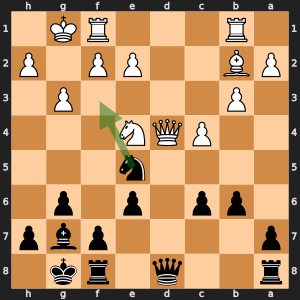

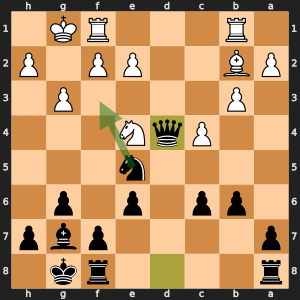

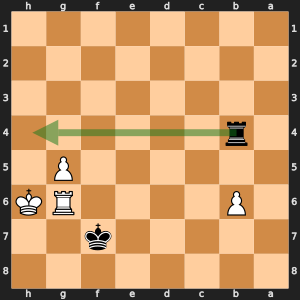

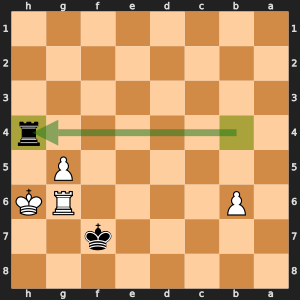

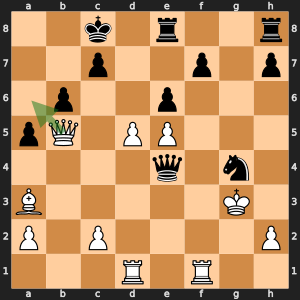

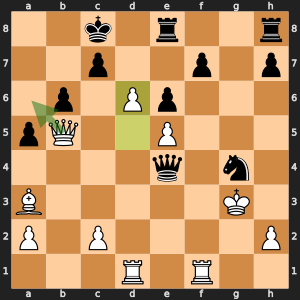

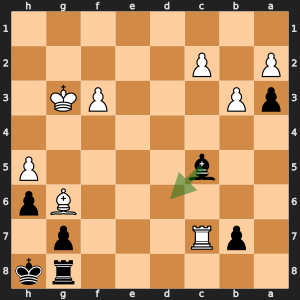

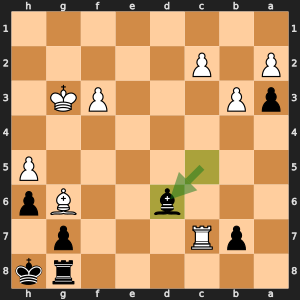

In [12]:
puzzles = generate_puzzles()
puzzles = shuffle_puzzles(puzzles)
visualize_puzzles(model=RDv2_player, puzzles=puzzles)